In [1]:
from IPython.display import display
from PIL import Image

import numpy as np
import torch

from deep_cloost.losses import MSELoss
from deep_cloost.model import Encoder, SVHNRefiner

In [2]:
def display_image(arr):
    """Helper to render a normalized SVHN image."""
    img = (np.clip(arr*0.5 + 0.5, 0, 1) * 255).astype('uint8')
    display(Image.fromarray(img.transpose(1, 2, 0)))

In [3]:
# Create the model and load it from a file.
#
# This model has 20 stages, where each stage
# chooses from 64 options.
encoder = Encoder(shape=(3, 32, 32),
                  options=64,
                  refiner=SVHNRefiner(64, 20),
                  loss_fn=MSELoss(),
                  num_stages=20)
encoder.load_state_dict(torch.load('pretrained/svhn_model.pt', map_location='cpu'))

<All keys matched successfully>

In [4]:
# Latent codes for this model are sequences of 20
# numbers between 0 and 64.
#
# Let's make an arbitrarily chosen latent code.
latents = torch.tensor([16, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                        0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.long)

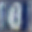

In [5]:
# The decode() method on our model allows us to
# produce an image for a latent code.
image = encoder.decode(latents[None])[0]
display_image(image.detach().numpy())

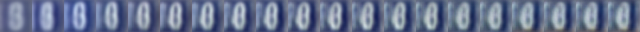

In [6]:
# We can also try decoding the image stage by stage
# to see how each stage modifies the output.
images = torch.cat([encoder.decode(latents[None], num_stages=i+1) for i in range(20)])
display_image(np.concatenate(images.detach().numpy(), axis=-1))

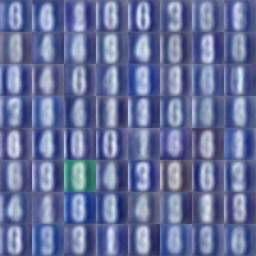

In [7]:
# The model works by proposing 64 different changes
# at each stage. Let's take a look at the options it
# proposed in the third stage.
stage = 3
partial_image = encoder.decode(latents[None], num_stages=stage-1)
proposals = encoder.apply_stage(stage-1, partial_image)[0]

# Create an 8x8 grid for the 64 proposals.
grid = proposals.view(8, 8, 3, 32, 32).detach().numpy()
image = np.concatenate(np.concatenate(grid, axis=-2), axis=-1)
display_image(image)

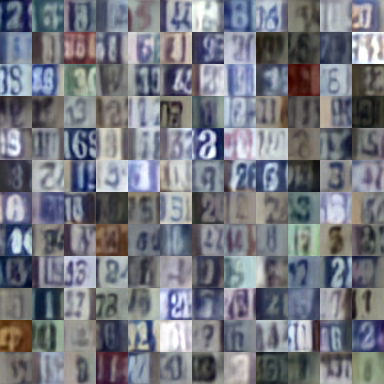

In [8]:
# Of course, the model can also decode latent codes
# in batch, giving us a neat grid of random samples.
latents = torch.randint(high=encoder.options, size=(12*12, encoder.num_stages))
with torch.no_grad():
    imgs = encoder.decode(latents)
grid = imgs.view(12, 12, 3, 32, 32).detach().numpy()
image = np.concatenate(np.concatenate(grid, axis=-2), axis=-1)
display_image(image)